# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import numpy as np
import os
from PIL import Image
import imageio
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [23]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
from keras import backend as K
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [24]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/val.csv').readlines())
batch_size = 32

#### Displaying a sample image

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [25]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.arange(0,30,2)
    while True:
        
        num_batches = len(folder_list)//batch_size
        batch_data, batch_labels = iterate_batches(source_path,folder_list,num_batches,img_idx,120,120)
        yield batch_data, batch_labels 

        remaining_batches = len(folder_list)%batch_size
        batch_data, batch_labels = iterate_batches(source_path,folder_list,num_batches,img_idx,120,120)
        yield batch_data, batch_labels 

In [26]:
def iterate_batches(source_path,folder_list,num_batches,img_idx,img_height,img_width):
    t = np.random.permutation(folder_list)
    for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = np.array(Image.fromarray((image * 255).astype(np.uint8)).resize((img_height, img_width)).convert('RGB'))
                    image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            return(batch_data,batch_labels)



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [27]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [28]:
def compileandbuildmodel(model):
    optimiser = 'sgd'
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    
    #Let us create the train_generator and the val_generator which will be used in .fit_generator.
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)
    callbacks_list = [checkpoint, LR]
    
    #The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
     
    #Fit the model This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

### CNN+LSTM

In [29]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'),
                 input_shape=(15,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(32, (2, 2))))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(128, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(64,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(5))
model.add(Activation('softmax'))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, 15, 120, 120, 16)  208      
 stributed)                                                      
                                                                 
 activation_12 (Activation)  (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization_8 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 119, 119, 32)  2080     
 stributed)                                                      
                                                                 
 activation_13 (Activation)  (None, 15, 119, 119, 32)  0         
                                                      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.4684 - categorical_accuracy: 0.3720  Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2022-03-1008_37_12.937567/model-00001-2.46836-0.37202-2.80700-0.25000.h5
21/21 [==============================] - 1906s 94s/step - loss: 2.4684 - categorical_accuracy: 0.3720 - val_loss: 2.8070 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 2.1399 - categorical_accuracy: 0.5595 
Epoch 2: saving model to model_init_2022-03-1008_37_12.937567/model-00002-2.13995-0.55952-2.71800-0.28906.h5
21/21 [==============================] - 683s 34s/step - loss: 2.1399 - categorical_accuracy: 0.5595 - val_loss: 2.7180 - val_categorical_accuracy: 0.2891 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.9899 - categorical_accuracy: 0.6176 
Epoch 3: saving model to model_init_2022-03-1008_3

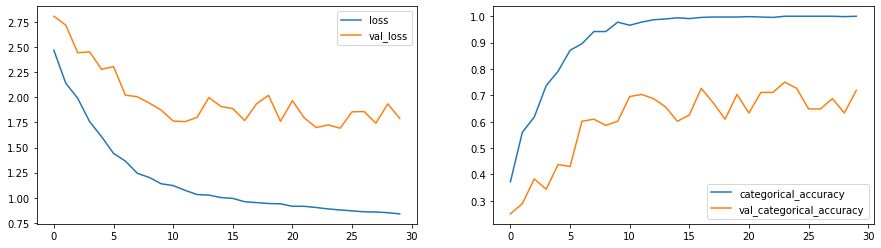

In [30]:
compileandbuildmodel(model)

### Increasing dropout as model is overfitting

In [31]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'),
                 input_shape=(15,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(32, (2, 2))))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(128, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.3))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(64,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(5))
model.add(Activation('softmax'))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeDi  (None, 15, 120, 120, 16)  208      
 stributed)                                                      
                                                                 
 activation_18 (Activation)  (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 time_distributed_22 (TimeDi  (None, 15, 119, 119, 32)  2080     
 stributed)                                                      
                                                                 
 activation_19 (Activation)  (None, 15, 119, 119, 32)  0         
                                                      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.5075 - categorical_accuracy: 0.3423Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2022-03-1008_37_12.937567/model-00001-2.50750-0.34226-2.79606-0.20312.h5
21/21 [==============================] - 106s 5s/step - loss: 2.5075 - categorical_accuracy: 0.3423 - val_loss: 2.7961 - val_categorical_accuracy: 0.2031 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 2.2253 - categorical_accuracy: 0.4940
Epoch 2: saving model to model_init_2022-03-1008_37_12.937567/model-00002-2.22535-0.49405-2.65167-0.35156.h5
21/21 [==============================] - 103s 5s/step - loss: 2.2253 - categorical_accuracy: 0.4940 - val_loss: 2.6517 - val_categorical_accuracy: 0.3516 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 2.0395 - categorical_accuracy: 0.5818
Epoch 3: saving model to model_init_2022-03-1008_37_12.93

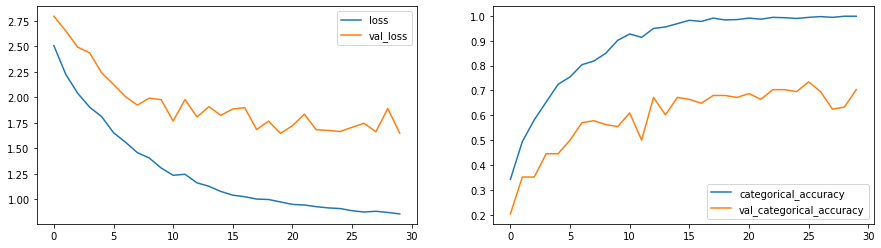

In [32]:
compileandbuildmodel(model)

### Reducing number of parameters and changing filter to (3,3)


In [43]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same'),
                 input_shape=(15,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(32, (3, 3))))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.3))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(128, return_sequences=False, dropout=0.5))
model.add(Dense(64,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(5))
model.add(Activation('softmax'))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_36 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 activation_40 (Activation)  (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 time_distributed_37 (TimeDi  (None, 15, 118, 118, 32)  4640     
 stributed)                                                      
                                                                 
 activation_41 (Activation)  (None, 15, 118, 118, 32)  0         
                                                      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.3789 - categorical_accuracy: 0.3185Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2022-03-1008_37_12.937567/model-00001-2.37885-0.31845-2.60842-0.21875.h5
21/21 [==============================] - 107s 5s/step - loss: 2.3789 - categorical_accuracy: 0.3185 - val_loss: 2.6084 - val_categorical_accuracy: 0.2188 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 2.1855 - categorical_accuracy: 0.4286
Epoch 2: saving model to model_init_2022-03-1008_37_12.937567/model-00002-2.18549-0.42857-2.72311-0.17969.h5
21/21 [==============================] - 98s 5s/step - loss: 2.1855 - categorical_accuracy: 0.4286 - val_loss: 2.7231 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 2.0110 - categorical_accuracy: 0.5402
Epoch 3: saving model to model_init_2022-03-1008_37_12.937

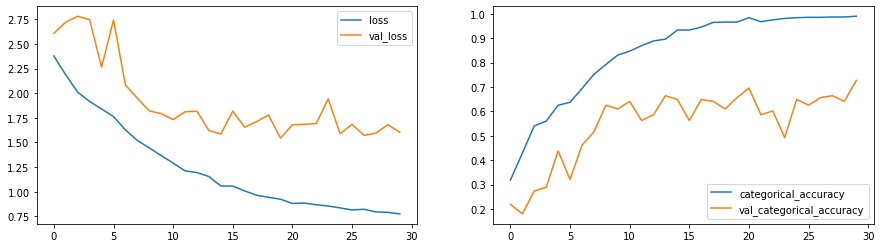

In [44]:
compileandbuildmodel(model)

### Using Transfer Learning

In [33]:
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)


model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(15,120,120,3)))
        
for layer in model.layers:
      layer.trainable = False
        
        
model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(64,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(5))
model.add(Activation('softmax'))

17235968/17225924 [==============================] - 0s 0us/step


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_28 (TimeDi  (None, 15, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 15, 9216)         0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 256)               9700352   
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 activation_24 (Activation)  (None, 64)                0         
                                                                 
 dropout_12 (Dropout)        (None, 64)               

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.6513 - categorical_accuracy: 0.2545Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2022-03-1008_37_12.937567/model-00001-2.65125-0.25446-2.55447-0.31250.h5
21/21 [==============================] - 101s 5s/step - loss: 2.6513 - categorical_accuracy: 0.2545 - val_loss: 2.5545 - val_categorical_accuracy: 0.3125 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 2.5448 - categorical_accuracy: 0.2827
Epoch 2: saving model to model_init_2022-03-1008_37_12.937567/model-00002-2.54479-0.28274-2.45813-0.36719.h5
21/21 [==============================] - 97s 5s/step - loss: 2.5448 - categorical_accuracy: 0.2827 - val_loss: 2.4581 - val_categorical_accuracy: 0.3672 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 2.4444 - categorical_accuracy: 0.4018
Epoch 3: saving model to model_init_2022-03-1008_37_12.937

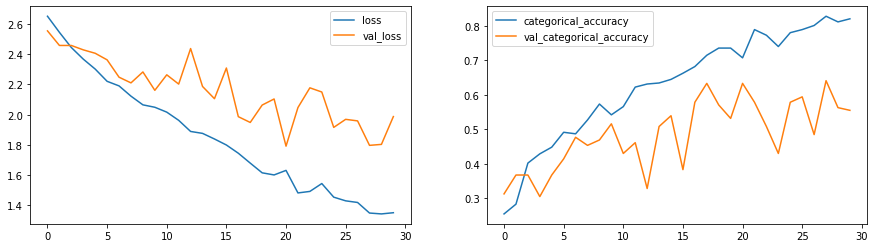

In [34]:
compileandbuildmodel(model)

### Conv 3D
'

In [35]:
from keras.layers.convolutional import Conv3D, MaxPooling3D
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(15,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16)  1312      
                                                                 
 activation_26 (Activation)  (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization_16 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 32)     4128      
                                                                 
 activation_27 (Activation)  (None, 7, 60, 60, 32)    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.5839 - categorical_accuracy: 0.3884Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2022-03-1008_37_12.937567/model-00001-1.58395-0.38839-9.18925-0.27344.h5
21/21 [==============================] - 97s 5s/step - loss: 1.5839 - categorical_accuracy: 0.3884 - val_loss: 9.1893 - val_categorical_accuracy: 0.2734 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.0199 - categorical_accuracy: 0.6012
Epoch 2: saving model to model_init_2022-03-1008_37_12.937567/model-00002-1.01986-0.60119-2.63191-0.22656.h5
21/21 [==============================] - 97s 5s/step - loss: 1.0199 - categorical_accuracy: 0.6012 - val_loss: 2.6319 - val_categorical_accuracy: 0.2266 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.7662 - categorical_accuracy: 0.7217
Epoch 3: saving model to model_init_2022-03-1008_37_12.9375

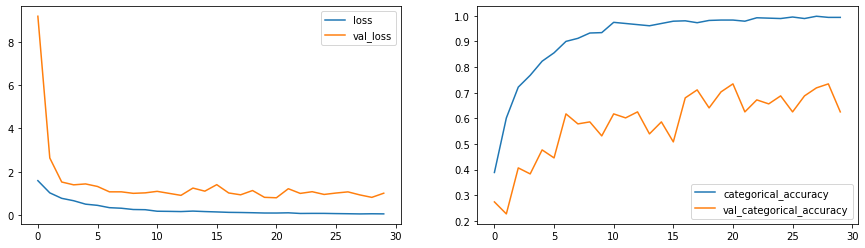

In [36]:
compileandbuildmodel(model)